In [23]:
import numpy as np
from pytorch_pretrained_vit import ViT
import torchvision
from torchvision import transforms
import torch
from deepface import DeepFace
from multiprocessing import Pool
import pandas as pd

import os
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix


warnings.filterwarnings('ignore')

In [2]:
model = ViT('B_16_imagenet1k', pretrained=True)

Loaded pretrained weights.


In [5]:
dataset_path = "data"

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(
    root=f'{dataset_path}/train',
    transform=data_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root=f'{dataset_path}/test',
    transform=data_transforms
)

batch_size = 64 


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,  # Define your batch size
    shuffle=True,           # Shuffle the data during training
    num_workers=4           # Number of CPU workers to load data in parallel (adjust as needed)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,  # Define your batch size for testing
    shuffle=False,          # Do not shuffle the data during testing
    num_workers=4           # Number of CPU workers to load data in parallel (adjust as needed)
)

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 7178
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


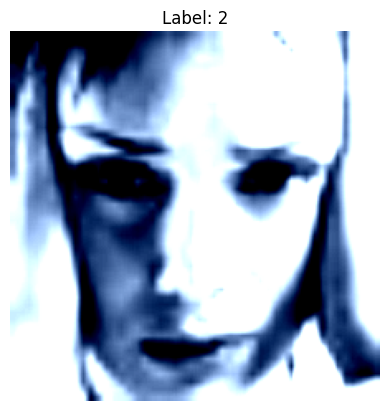

In [6]:
# Assuming you have already defined dataset_path, data_transforms, train_loader, and test_loader

# Get a batch of data (images and labels) from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Assuming you want to view the first image in the batch
idx = 0
sample_image = images[idx]  # Change the index if you want to view a different image
sample_label = labels[idx].item()  # Convert label tensor to a Python integer

# Convert the PyTorch tensor to a NumPy array and adjust the dimensions if necessary
sample_image = np.transpose(sample_image.numpy(), (1, 2, 0))  # Rearrange dimensions for RGB image

# Display the image
plt.imshow(sample_image)
plt.title(f'Label: {sample_label}')
plt.axis('off')  # Turn off axis
plt.show()


## Single Image

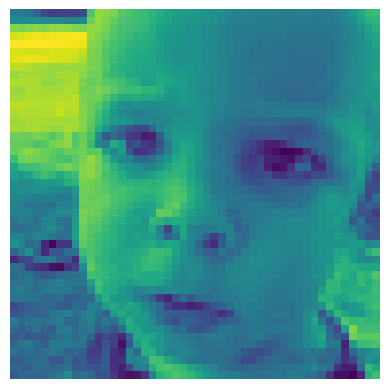

In [20]:
image_path = "data/train/angry/Training_1133567.jpg"

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  
plt.show()

In [21]:
result = DeepFace.analyze(img_path=image_path, actions=['emotion'], enforce_detection=False)
result[0]["emotion"]

Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.56it/s]


{'angry': 16.724903377902105,
 'disgust': 0.00795267238356912,
 'fear': 10.664186845518726,
 'happy': 0.3011452373614624,
 'sad': 49.972775581744244,
 'surprise': 0.3378825557893448,
 'neutral': 21.991150439840503}

In [22]:
max(result[0]["emotion"], key=result[0]["emotion"].get)

'sad'

## Test Results

In [20]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
directory = "data/test"

results = {}

for emotion in emotions:
    
    y_true = []
    y_pred = []

    emotion_images = [img for img in os.listdir(f"{directory}/{emotion}") if img.endswith(".jpg")]

    for img in emotion_images:
        result = DeepFace.analyze(img_path=f"{directory}/{emotion}/{img}", actions=['emotion'], enforce_detection=False)
        emotion_result = max(result[0]["emotion"], key=result[0]["emotion"].get)
        
        y_true.append(emotion)
        y_pred.append(emotion_result)

    # Calculate metrics using sklearn
    test_accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')

    results[emotion] = {
        "Test Accuracy": test_accuracy,
        "F1 Score": f1,
        "Recall": recall,
        "Precision": precision
    }

    # Print the results for each emotion
    print(f"Finished processing {emotion}.")
    print(f" - Test Accuracy: {results[emotion]['Test Accuracy']}")
    print(f" - F1 Score: {results[emotion]['F1 Score']}")
    print(f" - Recall: {results[emotion]['Recall']}")
    print(f" - Precision: {results[emotion]['Precision']}")
    print(f" - Processed {len(emotion_images)} images.\n")

print("Processing complete.")

Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  6.20it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 21.23it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Finished processing angry.
 - Test Accuracy: 0.42693110647181626
 - F1 Score: 0.085484376632877
 - Recall: 0.06099015806740232
 - Precision: 0.14285714285714285
 - Processed 958 images.



Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]


Finished processing disgust.
 - Test Accuracy: 0.45045045045045046
 - F1 Score: 0.10351966873706003
 - Recall: 0.07507507507507508
 - Precision: 0.16666666666666666
 - Processed 111 images.



Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 20.16it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Finished processing fear.
 - Test Accuracy: 0.419921875
 - F1 Score: 0.0844959717036746
 - Recall: 0.05998883928571429
 - Precision: 0.14285714285714285
 - Processed 1024 images.



Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.95it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.17it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 11.39it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 11.24it/s]


Finished processing happy.
 - Test Accuracy: 0.758173618940248
 - F1 Score: 0.12320798790821233
 - Recall: 0.108310516991464
 - Precision: 0.14285714285714285
 - Processed 1774 images.



Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.23it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 16.75it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


Finished processing neutral.
 - Test Accuracy: 0.5401459854014599
 - F1 Score: 0.10020311442112391
 - Recall: 0.07716371220020855
 - Precision: 0.14285714285714285
 - Processed 1233 images.



Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.58it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.33it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 16.87it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 16.18it/s]


Finished processing sad.
 - Test Accuracy: 0.41780272654370487
 - F1 Score: 0.08419521654815773
 - Recall: 0.05968610379195784
 - Precision: 0.14285714285714285
 - Processed 1247 images.



Action: emotion: 100%|████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 16.43it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]


Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00, 14.17it/s]


Finished processing surprise.
 - Test Accuracy: 0.703971119133574
 - F1 Score: 0.11803874092009685
 - Recall: 0.10056730273336771
 - Precision: 0.14285714285714285
 - Processed 831 images.

Processing complete.


In [22]:
pd.DataFrame(results)

,angry,disgust,fear,happy,neutral,sad,surprise
Test Accuracy,0.426931,0.450450,0.419922,0.758174,0.540146,0.417803,0.703971
F1 Score,0.085484,0.103520,0.084496,0.123208,0.100203,0.084195,0.118039
Recall,0.060990,0.075075,0.059989,0.108311,0.077164,0.059686,0.100567
Precision,0.142857,0.166667,0.142857,0.142857,0.142857,0.142857,0.142857


In [ ]:
"""
add confusion matrix
add graphs and shit
"""